<a href="https://www.kaggle.com/code/indranilbhattacharya/smape-and-jensen?scriptVersionId=122613546" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
import tqdm
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [2]:
def SMAPE(y_true, y_pred):
    ans = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            continue
        else:
            num = abs(y_true[i] - y_pred[i])
            denom = (abs(y_true[i]) + abs(y_pred[i]))/2
            ans = ans + (num/denom)
    return (100/len(y_true))*ans 

Assuming forecast and actual are both positive numbers, if we define $r$ as $r = forecast/actual$, then SMAPE is sum of Constant*$|r-1|/(r+1|)$

In [3]:
def ratio_forecast_observed(r):
    return abs(r-1)/(1+r)

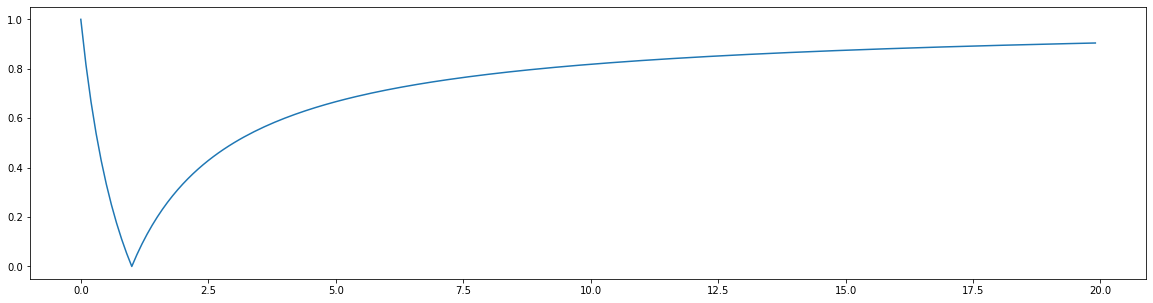

In [4]:
range_r = [i/10 for i in range(0,200)]
max(range_r)
test_smape = [ratio_forecast_observed(i) for i in range_r]
max(test_smape)
plt.plot(range_r, test_smape)

We observe that for greater values of r, we gets less penalized, meaning over predictions are safer than under predictions. A simple example. If the true labels are $1,2,3$, let's try with two predictions: $1.5,2.5,3.5$ and $0.5,1.5,2.5$. That is one is .5 higher for each point and one is .5 lower than each true labels

In [5]:
actual = [1,2,3]
forecast_above, forecast_below = [i+0.5 for i in actual], [i-0.5 for i in actual]
actual, forecast_above, forecast_below

([1, 2, 3], [1.5, 2.5, 3.5], [0.5, 1.5, 2.5])

In [6]:
SMAPE(actual, forecast_above), SMAPE(actual, forecast_below)

(25.868945868945872, 37.80663780663781)

We see that how underpredictions are worse than over predictions

Now, we come back to our data and first get the baseline validation SMAPE of last value

In [7]:
train_df = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv")
train_df.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active'],
      dtype='object')

In [8]:
val_true, val_pred_last = [], []
unique_tr_cfips = train_df.cfips.unique()
for cfips_temp in tqdm.tqdm(unique_tr_cfips):
    temp_train = train_df[train_df.cfips == cfips_temp]
    temp_train["first_day_of_month"] = pd.to_datetime(temp_train["first_day_of_month"])
    tr = temp_train.sort_values(by = "first_day_of_month")["microbusiness_density"].values.tolist()
    val_true.append(tr[-1])
    val_pred_last.append(tr[-2])

100%|██████████| 3135/3135 [00:04<00:00, 715.57it/s]


In [9]:
SMAPE(val_true, val_pred_last)

1.1011190959563653

Now, we simply create a AR(1) model and check the SMAPE validation score

In [10]:
val_true, val_pred_arima = [], []
for cfips_temp in tqdm.tqdm(unique_tr_cfips):
    temp_train = train_df[train_df.cfips == cfips_temp]
    temp_train["first_day_of_month"] = pd.to_datetime(temp_train["first_day_of_month"])
    tr = temp_train.sort_values(by = "first_day_of_month")["microbusiness_density"].values.tolist()
    tr, val = tr[:-1], tr[-1]
    order = (1,0,0)
    model = ARIMA(tr, order=order).fit()
    pred_val = model.forecast(1)
    val_true.append(val)
    val_pred_arima.append(pred_val[0])

100%|██████████| 3135/3135 [01:58<00:00, 26.43it/s]


In [11]:
SMAPE(val_true, val_pred_arima)

1.6312208233071308

This is worse than last value, but let's try some transformation on target. First we do a squared transformation on target and then we do squared root of predictions to get the validation score

In [12]:
## squared target ##
val_true, val_pred_arima_f = [], []
for cfips_temp in tqdm.tqdm(unique_tr_cfips):
    temp_train = train_df[train_df.cfips == cfips_temp]
    temp_train["first_day_of_month"] = pd.to_datetime(temp_train["first_day_of_month"])
    tr = temp_train.sort_values(by = "first_day_of_month")["microbusiness_density"].values.tolist()
    tr, val = tr[:-1], tr[-1]
    tr = [i*i for i in tr]
    order = (1,0,0)
    model = ARIMA(tr, order=order).fit()
    pred_val = model.forecast(1)
    pred_val = np.sqrt(pred_val)
    val_true.append(val)
    val_pred_arima_f.append(pred_val[0])

100%|██████████| 3135/3135 [01:34<00:00, 33.21it/s]


In [13]:
SMAPE(val_true, val_pred_arima_f)

1.8222816158910173

Now, we do a squared root transformation on target and then we do square predictions to get the validation score

In [14]:
## ## squared_rooted target ##
val_true, val_pred_arima_f_inv = [], []
for cfips_temp in tqdm.tqdm(unique_tr_cfips):
    temp_train = train_df[train_df.cfips == cfips_temp]
    temp_train["first_day_of_month"] = pd.to_datetime(temp_train["first_day_of_month"])
    tr = temp_train.sort_values(by = "first_day_of_month")["microbusiness_density"].values.tolist()
    tr, val = tr[:-1], tr[-1]
    tr = [np.sqrt(i) for i in tr]
    order = (1,0,0)
    model = ARIMA(tr, order=order).fit()
    pred_val = model.forecast(1)
    pred_val = pred_val*pred_val
    val_true.append(val)
    val_pred_arima_f_inv.append(pred_val[0])

100%|██████████| 3135/3135 [02:08<00:00, 24.42it/s]


In [15]:
SMAPE(val_true, val_pred_arima_f_inv)

1.5603324961156462

Seems like the squared root transformation on target helped atleast in validation

Now we do a log transformation on target and finally take exponentials of predictions

In [16]:
## ## log target ##
val_true, val_pred_arima_log = [], []
for cfips_temp in tqdm.tqdm(unique_tr_cfips):
    temp_train = train_df[train_df.cfips == cfips_temp]
    temp_train["first_day_of_month"] = pd.to_datetime(temp_train["first_day_of_month"])
    tr = temp_train.sort_values(by = "first_day_of_month")["microbusiness_density"].values.tolist()
    tr, val = tr[:-1], tr[-1]
    tr = [np.log(i+1e-12) for i in tr]
    order = (1,0,0)
    model = ARIMA(tr, order=order).fit()
    pred_val = model.forecast(1)
    pred_val = np.exp(pred_val)
    val_true.append(val)
    val_pred_arima_log.append(pred_val[0])

100%|██████████| 3135/3135 [02:06<00:00, 24.83it/s]


In [17]:
SMAPE(val_true, val_pred_arima_log)

1.574355345737363

Finally we do the exponential transformation on target and take log of predictions

In [18]:
## ## exp target ##
val_true, val_pred_arima_exp = [], []
for cfips_temp in tqdm.tqdm(unique_tr_cfips):
    temp_train = train_df[train_df.cfips == cfips_temp]
    temp_train["first_day_of_month"] = pd.to_datetime(temp_train["first_day_of_month"])
    tr = temp_train.sort_values(by = "first_day_of_month")["microbusiness_density"].values.tolist()
    tr, val = tr[:-1], tr[-1]
    tr = [np.exp(i) for i in tr]
    order = (1,0,0)
    model = ARIMA(tr, order=order).fit()
    pred_val = model.forecast(1)
    pred_val = np.log(pred_val)
    val_true.append(val)
    val_pred_arima_exp.append(pred_val[0])

100%|██████████| 3135/3135 [01:26<00:00, 36.31it/s]


In [19]:
SMAPE(val_true, val_pred_arima_exp)

2.5033906228174123

So, our final observation is that the squared root trasformation or a log trnasformation on target and then inverse transformation on predictions might help when we are using a linear model. Now, what is the similarity between these two transformations, they are concave functions. So is there a Jensen's inequality that is playing it's part? I do not know :D